In [1]:
import argparse
import collections
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import dmc_remastered as dmcr

from dm_control import suite
from matplotlib import animation
from algos.dreamer_mpc import DreamerMPC
from algos.dreamer_sac import DreamerSAC
from algos.dreamer_value import DreamerValue
from wrappers.action_repeat_wrapper import ActionRepeat
from wrappers.frame_stack_wrapper import FrameStack
from wrappers.gym_wrapper import GymWrapper
from wrappers.pixel_observation_wrapper import PixelObservation

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def save_video_as_gif(frames):
    """
    make video with given frames and save as "video_prediction.gif"
    """
    plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title('Left: GT frame' + ' '*20 + 'Right: predicted frame \n Step %d' % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=150)
    anim.save('video_prediction.gif', writer='imagemagick')

In [3]:
args = {
    'train_args_dir': '/Users/jan/Development/Projects/thesis/output/cheetah-run-2021-04-24-23-22-53/config/args.json',
    'load_model_dir': '/Users/jan/Development/Projects/thesis/output/cheetah-run-2021-04-24-23-22-53/model/model_final',
    'video_length': 100
}

with open(args['train_args_dir']) as json_file:
    config = json.load(json_file)
config.update(args)
keys = config.keys()
values = config.values()
args = collections.namedtuple('args', keys)(* values)

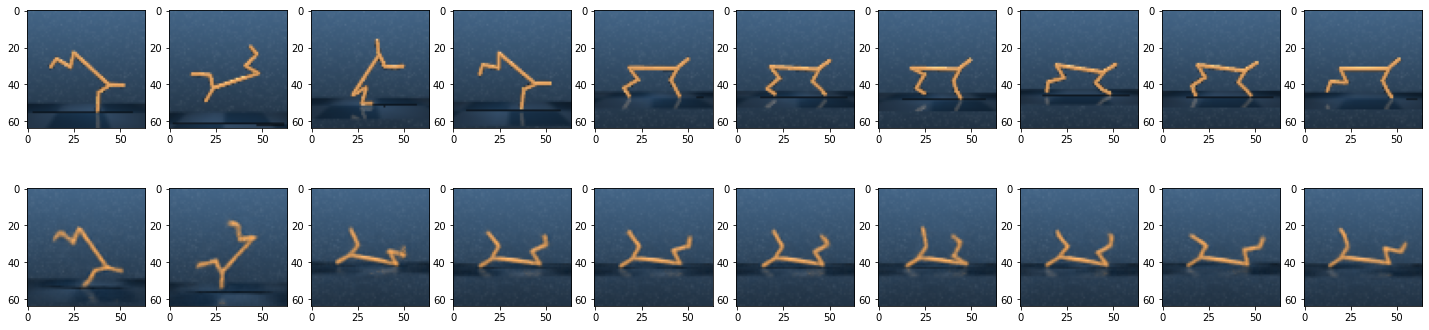

In [5]:
# create dm_control env
if args.randomize_env:
    _, env = dmcr.benchmarks.visual_generalization(args.domain_name, args.task_name, num_levels=100)
else:
    env = suite.load(args.domain_name, args.task_name, task_kwargs={'random': args.seed})
    env = GymWrapper(env)

# augment observations by pixel values
env = PixelObservation(env, args.observation_size)

# stack several consecutive frames together
env = FrameStack(env, args.frame_stack)

# repeat actions
env = ActionRepeat(env, args.action_repeat)

# define models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_args = {
    'observation_shape': env.observation_space.shape,
    'action_dim': env.action_space.shape[0],
    'action_range': [
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ]
}
config.update(env_args)
keys = config.keys()
values = config.values()
args = collections.namedtuple('args', keys)(*values)

# algorithm
if hasattr(args, 'sac_batch_size'):
    algorithm = DreamerSAC(env, None, None, device, args)
elif hasattr(args, 'value_eps'):
    algorithm = DreamerValue(env, None, None, device, args)
elif hasattr(args, 'controller_type'):
    algorithm = DreamerMPC(env, None, None, device, args)
else:
    raise ValueError('configuration file not valid')

# load models
algorithm.load_model(args.load_model_dir)

obs = env.reset()
# starting_point = torch.randint(1000 // args.action_repeat - args.video_length, (1,)).item()
starting_point = 200
for _ in range(starting_point):
    action = algorithm.agent.get_action(obs)
    obs, _, _, _ = env.step(action)
    env.render()
obs = torch.as_tensor(obs, device=device)

# embed observations
embedded_observation = algorithm.observation_encoder(obs.unsqueeze(0))

# create figure
fig = plt.figure(figsize=(25, 6))
columns = 10
rows = 2

rnn_hidden = algorithm.agent.rnn_hidden
state = algorithm.rssm.posterior(rnn_hidden, embedded_observation).sample()
frame = np.zeros((3, 64, 128))
frames = []
for i in range(args.video_length + 1):
    # action is selected same as training time (closed-loop)
    #action = algorithm.agent.get_action(obs)
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)

    # update state and reconstruct observation with same action
    action = torch.as_tensor(action, device=device).unsqueeze(0)
    with torch.no_grad():
        state_prior, rnn_hidden = algorithm.rssm.prior(state, action, rnn_hidden)
        state = state_prior.sample()
        predicted_obs = algorithm.observation_decoder(state, rnn_hidden)
        
    # plot
    if i % 10 == 0 and i != 0:
        fig.add_subplot(rows, columns, int(i / 10))
        plt.imshow(np.moveaxis(obs + 0.5, 0, -1).clip(0.0, 1.0))
        fig.add_subplot(rows, columns, int(i / 10) + 10)
        plt.imshow((predicted_obs.squeeze(0).transpose(0, 1).transpose(1, 2) + 0.5).clip(0.0, 1.0))

    # arrange GT frame and predicted frame in parallel
    frame[:, :, :64] = obs
    frame[:, :, 64:] = predicted_obs.squeeze().cpu().numpy()
    frame = np.moveaxis(frame, 0, -1)
    frames.append((frame + 0.5).clip(0.0, 1.0))
    frame = np.zeros((3, 64, 128))
plt.show()

# save_video_as_gif(frames)